# Conversion Rate

### Data Preprocessing

In [31]:
#Importing the libraries we are going to need
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import graphviz

%matplotlib inline

In [32]:
#Importing the dataset 
data=pd.read_csv("https://drive.google.com/uc?export=download&id=1KvxyyF3QCtvIx0J7_8iWDEtFQpLgd0Yq")

In [33]:
#Printing the Basic descriptive statistics of the dataset
print(data.head())
print(data.info())
print(data.describe())
print(data.groupby(['country']).size())
print(data.groupby(['source']).size())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
None
                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.68546

Some Preliminary observations. 
- The dataset has around 30,000 datapoints, implying that we have a large enough dataset to draw conclusions from (Central Limit Theorem)
- The user base is mostly young, with the upto 75% of the users in their mid 30s. 
- While the e-commerce focuses primarily on US consumers, it has a small customer base in China, with sales being higher than Germany and UK. 
- However, considering how China is the 2nd most populous country in the world, it doesn't fare well compared to the US. This is one of the factors to be looked into. 
- The average conversion rate is around 3.2% which is the industry standard. If there are 100 users on the website, around 3 of them will buy the product. 
- However, it seems that the maximum is 123. Since, the e-commerce is not targeting for the age group above 100, we can remove these datapoints as outliers. 

In [34]:
#Looking at the number of people more than 100
data[data['age'] >= 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


We can remove the above consumers, even though they purhcased the product.

In [35]:
#Removing the 2 datapoints with age > 100 from the dataset.
data = data[data['age'] < 100]

In [36]:
#Checking for any missing data
data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

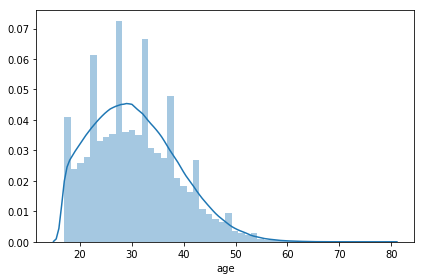

In [37]:
#Visualizing the 'age' distribution
sns.distplot(data['age'])

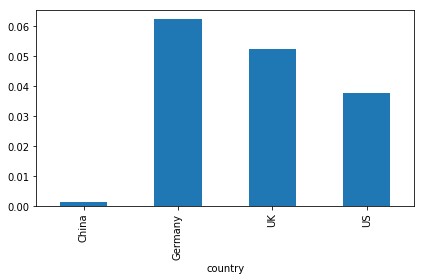

In [38]:
#Visualizing conversions by country
rcParams.update({'figure.autolayout': True})
data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

While china has a larger number of visitors on the site, it has much lower rate of conversion. 
Most probably cause :
- Language Barrier 
- Lack of Chinese items 
- Lack of items that foreigners/visitors expect to buy from American websites because of its unavailability in homeland.(souvenires, Sports Jerseys, Highend fashion apparrel, Hip-Hop Merchandise) 

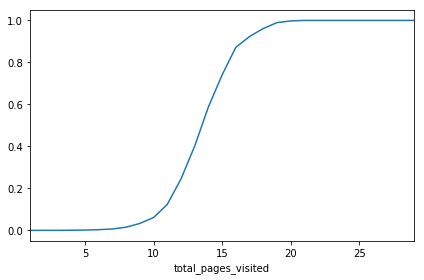

In [39]:
#Visualizing the conversion of a site by 'total_sales_visited'
data.groupby(['total_pages_visited'])['converted'].mean().plot()

The above graph shows that spending more time on the website, leads to higher conversions. However, it would be ideal if the consumer visits lower number of pages to purchase a product. The average consumer who is 80% converted for the purchase goes through 17 pages. 

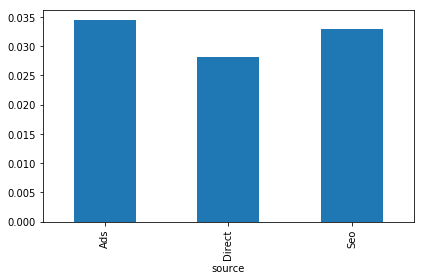

In [40]:
#Visualizing the conversion based on 'source'
data.groupby(['source'])['converted'].mean().plot.bar()

## Machine Learning 


I am going to create test/training set with a standard 66% split (if the data were too small, I would cross-validate). Then, I am going to build the forest with standard values for the 3 important parameters (100 trees, trees as large as possible, 3 random variables selected at each split).

Since we working with determing if a visitor on the website can convert or not, I am going to choose a Classification Algorithm. 

I am going to pick a random forest to predict conversion rate. I picked a random forest because: it usually requires very little time to optimize it (its default params are often close to be the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. Also, I will build a simple tree to find the most obvious user segments.

In [41]:
#Importing the model
from sklearn.ensemble import RandomForestClassifier

In [42]:
#I am going to create dummy variable, since it makes it easier to work with machine learning algorithm. 
data_dummy = pd.get_dummies(data,drop_first = True)

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)
  
#splitting into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)
  
#initializing the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9838851885571901 
 OOB Confusion Matrix 
         0     1
0  200872  1102
1    2261  4455


Out-of-bag (OOB) error, measures the prediction error of random forests, boosted decision trees, and other machine learning models utilizing bootstrap aggregating (bagging). OOB is the mean prediction error on each training sample.

In [44]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


The OOB and test accuracy is pretty similiar which suggests that we are not overfitting.

## Exploring Feature Importance

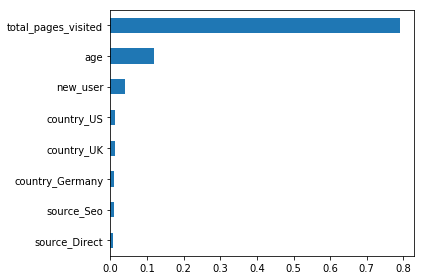

In [45]:
#Visualizing the distribution of the weight of the features on the conversion 
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Total pages visited is the most important feature. However, it is probably the least “addresssable” variable because People visit many pages because they already want to buy. The process of completing a purchase includes atleast  visiting the following 5 pages:

- Home Page
- Search results 
- Product page (if the search result is accurate)
- Payment and Shipping page
- Payment confirmation page


We are going to redo Random Forrest Initialization without "Total_pages_visited" variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weights, just to make sure we will get something classified as 1.



In [46]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978


In [47]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


The new model has reduced accuracy. However, the accuracy has reduced only by approximately 2-3% after dropping one feature. We are going to recalculate variable importance:

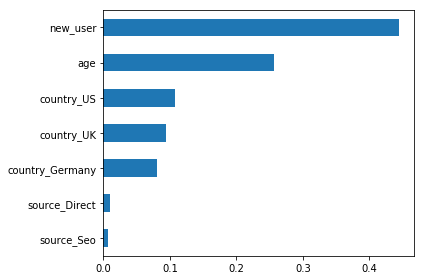

In [48]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

From the above graph, New user is the most important one, even more important than age. And that’s impressive given that continuous variables tend to always show up at the top in RF variable importance plots. It means new_user is really important. Source-related dummies don’t seem to matter at all.


Let’s check partial dependence plots for the 4 vars:

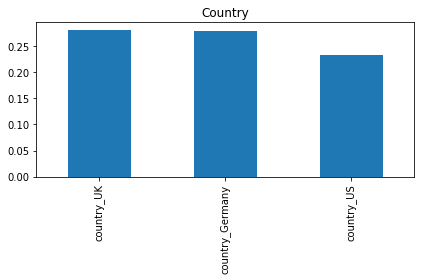

In [22]:
from pdpbox import pdp, info_plots
  
#Visualizing the partial dependence by country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()


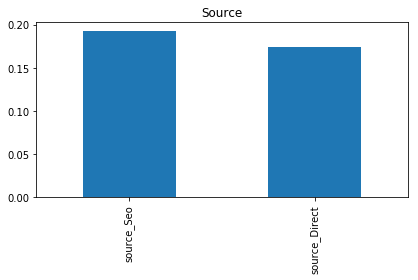

In [23]:
#source
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

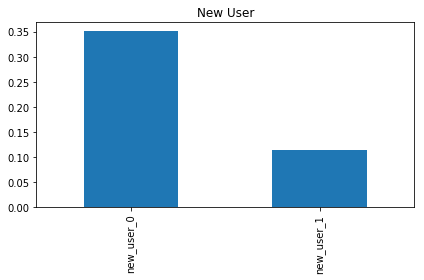

In [24]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

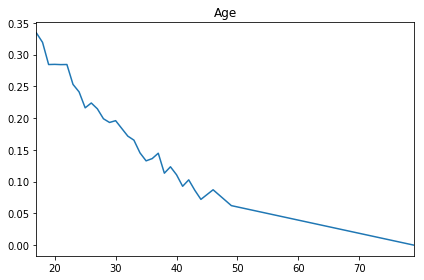

In [25]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

This shows that:

- Users with an old account are much better than new users

- Germany, UK, and US are similar, with Germany being the best. Most importantly, they all have very very high values. As usual, we have to read this as relative to the reference level, which is China. So this means that not being from China and being from any of those 3 countries significantly increases the probability of conversion. That is, China is very bad for conversion

- The site works very well for young people and gets worse for >30 yr old

- Source is less relevant


Let’s now build a simple decision tree and check the 2 or 3 most important segments:

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_conversion.dot")
s.view()

#A simple small tree confirms exactly the random forest findings.

'tree_conversion.dot.pdf'

## Conversion

The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.


As you can see, product ideas usually end up being about:

Identify segments that perform well, but have low absolute count (like Germany). Then tell marketing to get more of those people

Tell product to fix the experience for the bad performing ones

Bad performing segments with high absolute count (like China) usually provide the biggest opportunities for massive gains, if you can guess why that’s happening and then build a test to validate your hypothesis



